In [1]:
# imports
from kmsr import KMSR
from sklearn.datasets import make_blobs
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.metrics import DistanceMetric
import random

# FPT Approximations for Fair k-Min-Sum-Radii

### Creating example data

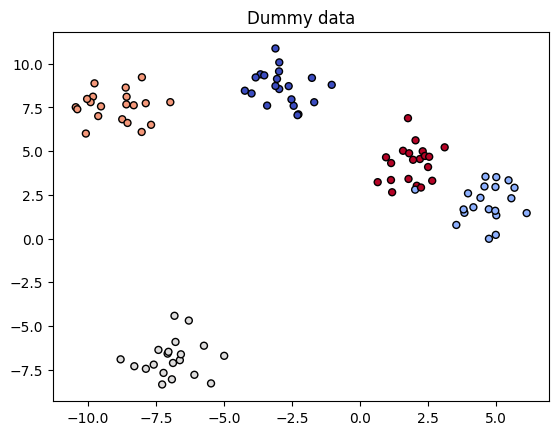

In [2]:
# generate dummy data
k = 5
points, cluster_membership = make_blobs(
    n_samples=100,
    n_features=2,
    centers=k,
    random_state=42
)

plt.title("Dummy data")
plt.scatter(points[:, 0], points[:, 1], marker='o', c=cluster_membership, s=25, edgecolor="k", cmap="coolwarm")
plt.show()


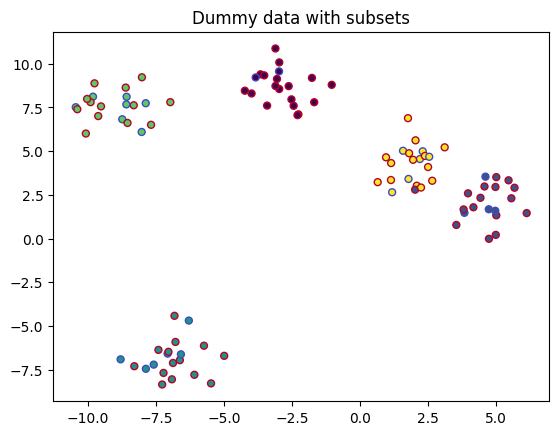

In [3]:
# choosing points to represent two subsets in 1:3 ratio:
subset_membership = np.array([10 if index % 4 == 0 else 200 for index in range(len(points))])


cmap=plt.cm.coolwarm
norm = mcolors.Normalize(vmin=min(subset_membership), vmax=max(subset_membership))
edge_colors = cmap(norm(subset_membership))
plt.title("Dummy data with subsets")
plt.scatter(points[:, 0], points[:, 1], marker='o',c=cluster_membership, s=25, edgecolor=edge_colors)
plt.show()

## The Algorithm

### 1. Constructing unfair clusters that contain the optimal solution
Necessary subroutines: guessing centers -> k-completion -> Gonzalez, guessing radii 

In [4]:
# distance function
dist = DistanceMetric.get_metric('euclidean')

To better understand the following k_completion implementation, it is helpful to first remember the basics of farthest-first traversal implemented in Gonzalez. This algorithm already achieves a 2-approximation for unfair clustering, which leads to remarkably accurate centers, even if you start with a randomly selected one.

In [5]:
def gonzalez(points, k):
    points = np.array(points)
    n = len(points)
    centers = []

    start_idx = np.random.choice(n)
    centers.append(points[start_idx])
    
    if(k==1):
        return centers

    while(len(centers) < k):
        dists = np.min(dist.pairwise(points, np.array(centers)), axis=1) # the axis attribute stops it from returning the same center over and over again
        
        farthest_idx = np.argmax(dists)
        centers.append(points[farthest_idx])

    return np.array(centers)
print("Example:")
print(gonzalez(points, 5))

Example:
[[  5.00151486   1.32804993]
 [-10.44581099   7.50815677]
 [ -7.27173534  -8.34362454]
 [ -1.04354885   8.78850983]
 [  1.1384428    4.31517666]]


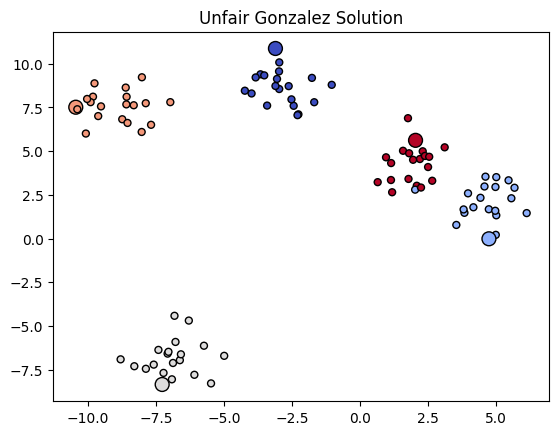

In [6]:
# centers are enlarged
gonzalez_solution = gonzalez(points, 5)
plt.title("Unfair Gonzalez Solution")
sizes = [100 if tuple(point) in map(tuple, gonzalez_solution) else 25 for point in points]
plt.scatter(points[:, 0], points[:, 1], marker='o', c=cluster_membership, s=sizes, edgecolor="k", cmap="coolwarm")
plt.show()

In [7]:
def k_completion(points, centers, k):

    if(k==len(centers)):
        return centers
    
    if(len(centers)==0):
        centers.append(points[np.random.choice(len(points))])

    while(len(centers) < k):
        dists = np.min(dist.pairwise(points, np.array(centers)), axis=1) # the axis attribute stops it from returning the same center over and over again
        
        farthest_idx = np.argmax(dists)
        centers.append(points[farthest_idx])

    return centers

#### Modified distance function
However, this approach might fail for overlapping clusters as described in the paper (figure 2). Due to this, we first want to guess a radius profile that we can then fit to guessed centers, using a modified distance function.

In [8]:
def dist_m(point_a, point_b, centers, radii):
    if point_a and point_b in centers:
        return max(dist(point_a, point_b) - radii[centers.index(point_a)] - radii[centers.index(point_b)], 0)
    elif point_a in centers:
        return max(dist(point_a, point_b) - radii[centers.index(point_a)], 0)
    elif point_b in centers:
        return max(dist(point_a, point_b) - radii[centers.index(point_b)], 0)
    else:
        return dist(point_a, point_b)

### Guessing radii
For ease of implementation, we assume epsilon to be 0.5.\\
We also need an Approximation for a k-msr solution, for which we will use a heursitic approach developed in https://github.com/algo-hhu/k-min-sum-radii

#### Approximation of kmsr
For an upper bound of possible radii, we approximate a kmsr solution

In [9]:
# estimation of kmsr
def kmsr_heuristic(points, k):
    kmsr = KMSR(n_clusters=k,
                algorithm="FPT-heuristic",
                epsilon=0.5,
                n_u=10000,
                n_test_radii=10,
                random_state=42)
    kmsr.fit(points)
    return kmsr.cluster_radii_

In [10]:
def guessing_radii(points, k):
    radii = []
    # first we need to guess the largest radius, to decrease our guessing interval from there
    # for that we need an estimated kmsr solution as upper bound
    kmsr = kmsr_heuristic(points, k)
    # because we used a 1+epsilon approximation, we can simlify the equation a lot
    epsilon = 0.5
    for radius in kmsr:
        radii.append((1+epsilon)*radius)
    return radii


solution = guessing_radii(points, k)
print(solution)  

C:\Users\Mattis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
C:\Users\Mattis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[2.922881344882015, 3.1921825473361976, 5.632482256549338, 2.881743629187725]


## 1st step algorithm
Described as Algorithm 2 in the paper

In [ ]:
def algorithm_2(points, k, radii, assignment_tuple):
    guessed_centers = k_completion(points=points, centers = [], k=k)
    print(guessed_centers)
    for i in range(k):
        print(i)
        temp_centers = guessed_centers[:i+1].extend(k_completion(points=points, centers = guessed_centers[:i+1], k=k))
        print(temp_centers)
        if(assignment_tuple[i]<i):
            radii[assignment_tuple[i]] += 3 * radii[i]
            radii[i] == 0
            temp_centers[i] == random.choice(points)
        elif(assignment_tuple[i] >= i):
            temp_centers[i] = temp_centers[assignment_tuple[i]]
            radii[i] = 3 * radii[i]
        guessed_centers = k_completion(points=points, centers=temp_centers[:i+1], k=k)
    return guessed_centers, radii

print(algorithm_2(points, k, guessing_radii(points, k), assignment_tuple=[0, 1, 2, 3, 4]))

C:\Users\Mattis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
C:\Users\Mattis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[array([-8.79839841, -6.90662347]), array([-3.11090424, 10.86656431]), array([ 4.73163961, -0.01439923]), array([-10.07527847,   6.0030663 ]), array([1.7576434 , 6.88162072])]
0
None


TypeError: 'NoneType' object is not subscriptable